In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/Dataset'

if os.path.exists(base_dir):
    print(f"Klasör bulundu: {base_dir}")
    print("İçerik:", os.listdir(base_dir))
else:
    print("Klasör bulunamadı! Lütfen Drive yolunu kontrol edin.")

Mounted at /content/drive
Klasör bulundu: /content/drive/MyDrive/Dataset
İçerik: ['Testing', 'Training']


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

!pip install keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.regularizers import l2

warnings.filterwarnings("ignore")
print("Kütüphaneler yüklendi.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.1 MB/s eta 0:00:00
Kütüphaneler yüklendi.


In [ ]:


dataset_path = Path('/content/drive/MyDrive/Dataset/Training')

filepaths = list(dataset_path.glob(r"**/*.png")) + list(dataset_path.glob(r"**/*.jpg"))


labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name="filepath").astype(str)
labels = pd.Series(labels, name="label")
image_df = pd.concat([filepaths, labels], axis=1)

print(f"Eğitim Klasöründeki Toplam Resim: {len(image_df)}")



test_dataset_path = Path('/content/drive/MyDrive/Dataset/Testing')

test_filepaths = list(test_dataset_path.glob(r"**/*.png")) + list(test_dataset_path.glob(r"**/*.jpg"))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

test_filepaths_series = pd.Series(test_filepaths, name="filepath").astype(str)
test_labels_series = pd.Series(test_labels, name="label")
test_df = pd.concat([test_filepaths_series, test_labels_series], axis=1)

print(f"Test Klasöründeki Toplam Resim: {len(test_df)}")


train_df, val_df = train_test_split(
    image_df,
    test_size=0.20,
    random_state=42,
    shuffle=True,
    stratify=image_df['label']
)

print("-" * 30)
print(f"Eğitim Seti (Split Sonrası): {len(train_df)}")
print(f"Doğrulama Seti (Split Sonrası): {len(val_df)}")
print(f"Test Seti (Harici Klasör): {len(test_df)}")

Eğitim Klasöründeki Toplam Resim: 5726
Test Klasöründeki Toplam Resim: 1311
------------------------------
Eğitim Seti (Split Sonrası): 4580
Doğrulama Seti (Split Sonrası): 1146
Test Seti (Harici Klasör): 1311


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 64

# --- Augmentation (Veri Çoğaltma) Ayarları ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Generator'ları Oluşturma ---
print("Eğitim verisi hazırlanıyor...")
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    color_mode="grayscale", 
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Doğrulama verisi hazırlanıyor...")
validation_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    color_mode="grayscale",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Test verisi hazırlanıyor...")
test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Eğitim verisi hazırlanıyor...
Found 4580 validated image filenames belonging to 4 classes.
Doğrulama verisi hazırlanıyor...
Found 1146 validated image filenames belonging to 4 classes.
Test verisi hazırlanıyor...
Found 1311 validated image filenames belonging to 4 classes.


In [ ]:
model = Sequential()

# 1. Blok
model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", input_shape=(224, 224, 1)))
model.add(MaxPool2D((2, 2)))

# 2. Blok
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))

# 3. Blok
model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

# 4. Blok
model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model.add(MaxPool2D((2, 2)))



# Sınıflandırma Katmanı
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=4, activation="softmax")) 

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,975,556 (49.50 MB)

 Trainable params: 12,975,428 (49.50 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:

%load_ext tensorboard


MONITOR_METRIC = 'val_loss'

tensorboard_callback = TensorBoard(log_dir="logs")

reduce_lr = ReduceLROnPlateau(
    monitor=MONITOR_METRIC,
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor=MONITOR_METRIC,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

checkpoint_filepath = '/content/drive/MyDrive/CnnSavedModels/best_model.keras'

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5', 
    monitor=MONITOR_METRIC,
    save_best_only=True,
    verbose=1
)

my_callbacks = [tensorboard_callback, reduce_lr, early_stopping, model_checkpoint]

print("Model Eğitimi Başlıyor...")

EPOCHS = 100

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=my_callbacks
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Model Eğitimi Başlıyor...
Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - accuracy: 0.4425 - loss: 1.9976 
Epoch 1: val_loss improved from inf to 1.33871, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 1458s 20s/step - accuracy: 0.4440 - loss: 1.9882 - val_accuracy: 0.5951 - val_loss: 1.3387 - learning_rate: 1.0000e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6652 - loss: 0.8521
Epoch 2: val_loss improved from 1.33871 to 1.25118, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 590ms/step - accuracy: 0.6652 - loss: 0.8519 - val_accuracy: 0.7251 - val_loss: 1.2512 - learning_rate: 1.0000e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.6909 - loss: 0.7698
Epoch 3: val_loss improved from 1.25118 to 1.13595, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 591ms/step - accuracy: 0.6911 - loss: 0.7695 - val_accuracy: 0.7478 - val_loss: 1.1360 - learning_rate: 1.0000e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.7375 - loss: 0.6718
Epoch 4: val_loss improved from 1.13595 to 1.02753, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step - accuracy: 0.7376 - loss: 0.6717 - val_accuracy: 0.7818 - val_loss: 1.0275 - learning_rate: 1.0000e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7669 - loss: 0.5902
Epoch 5: val_loss improved from 1.02753 to 0.90118, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 610ms/step - accuracy: 0.7667 - loss: 0.5904 - val_accuracy: 0.7818 - val_loss: 0.9012 - learning_rate: 1.0000e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.7802 - loss: 0.5794
Epoch 6: val_loss improved from 0.90118 to 0.73756, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 593ms/step - accuracy: 0.7802 - loss: 0.5792 - val_accuracy: 0.7347 - val_loss: 0.7376 - learning_rate: 1.0000e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.7871 - loss: 0.5548
Epoch 7: val_loss improved from 0.73756 to 0.60073, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 594ms/step - accuracy: 0.7870 - loss: 0.5549 - val_accuracy: 0.7548 - val_loss: 0.6007 - learning_rate: 1.0000e-04
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8087 - loss: 0.5162
Epoch 8: val_loss improved from 0.60073 to 0.50354, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 82s 597ms/step - accuracy: 0.8086 - loss: 0.5165 - val_accuracy: 0.8133 - val_loss: 0.5035 - learning_rate: 1.0000e-04
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8055 - loss: 0.5210
Epoch 9: val_loss improved from 0.50354 to 0.48328, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 584ms/step - accuracy: 0.8055 - loss: 0.5210 - val_accuracy: 0.8054 - val_loss: 0.4833 - learning_rate: 1.0000e-04
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.8094 - loss: 0.5097
Epoch 10: val_loss did not improve from 0.48328
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 582ms/step - accuracy: 0.8094 - loss: 0.5096 - val_accuracy: 0.7260 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.8116 - loss: 0.4791
Epoch 11: val_loss did not improve from 0.48328
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 581ms/step - accuracy: 0.8116 - loss: 0.4791 - val_accuracy: 0.7723 - val_loss: 0.4916 - learning_rate: 1.0000e-04
Epoch 12/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.8106 - loss: 0.5010
Epoch 12: val_loss did not improve from 0.48328
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 591ms/step - accuracy: 0.8107 - loss: 0.5007 - val_accuracy: 0.7784 - val_loss: 0.4929 - learning_rate: 1.0000e-04
Epoch 13

72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 590ms/step - accuracy: 0.8344 - loss: 0.4192 - val_accuracy: 0.8403 - val_loss: 0.3981 - learning_rate: 1.0000e-04
Epoch 15/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8320 - loss: 0.4252
Epoch 15: val_loss improved from 0.39809 to 0.37989, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 579ms/step - accuracy: 0.8321 - loss: 0.4252 - val_accuracy: 0.8368 - val_loss: 0.3799 - learning_rate: 1.0000e-04
Epoch 16/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8427 - loss: 0.4263
Epoch 16: val_loss did not improve from 0.37989
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 577ms/step - accuracy: 0.8426 - loss: 0.4262 - val_accuracy: 0.8621 - val_loss: 0.3824 - learning_rate: 1.0000e-04
Epoch 17/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.8388 - loss: 0.4383
Epoch 17: val_loss did not improve from 0.37989
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.8389 - loss: 0.4381 - val_accuracy: 0.7539 - val_loss: 0.7088 - learning_rate: 1.0000e-04
Epoch 18/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8424 - loss: 0.4060
Epoch 18: val_loss improved from 0.37989 to 0.37752, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 572ms/step - accuracy: 0.8424 - loss: 0.4059 - val_accuracy: 0.8455 - val_loss: 0.3775 - learning_rate: 1.0000e-04
Epoch 19/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8437 - loss: 0.4003
Epoch 19: val_loss improved from 0.37752 to 0.33380, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.8438 - loss: 0.4001 - val_accuracy: 0.8656 - val_loss: 0.3338 - learning_rate: 1.0000e-04
Epoch 20/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.8532 - loss: 0.3697
Epoch 20: val_loss did not improve from 0.33380
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 573ms/step - accuracy: 0.8532 - loss: 0.3699 - val_accuracy: 0.8168 - val_loss: 0.4454 - learning_rate: 1.0000e-04
Epoch 21/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8510 - loss: 0.3809
Epoch 21: val_loss did not improve from 0.33380
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.8510 - loss: 0.3810 - val_accuracy: 0.8089 - val_loss: 0.5007 - learning_rate: 1.0000e-04
Epoch 22/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.8674 - loss: 0.3613
Epoch 22: val_loss improved from 0.33380 to 0.33131, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 596ms/step - accuracy: 0.8674 - loss: 0.3612 - val_accuracy: 0.8796 - val_loss: 0.3313 - learning_rate: 1.0000e-04
Epoch 23/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8645 - loss: 0.3684
Epoch 23: val_loss did not improve from 0.33131
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 564ms/step - accuracy: 0.8645 - loss: 0.3685 - val_accuracy: 0.8054 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 24/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8638 - loss: 0.3362
Epoch 24: val_loss did not improve from 0.33131
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8637 - loss: 0.3365 - val_accuracy: 0.8639 - val_loss: 0.3468 - learning_rate: 1.0000e-04
Epoch 25/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8676 - loss: 0.3414
Epoch 25: val_loss improved from 0.33131 to 0.31082, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 578ms/step - accuracy: 0.8676 - loss: 0.3414 - val_accuracy: 0.8735 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 26/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.8683 - loss: 0.3412
Epoch 26: val_loss did not improve from 0.31082
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 568ms/step - accuracy: 0.8682 - loss: 0.3413 - val_accuracy: 0.7417 - val_loss: 0.8048 - learning_rate: 1.0000e-04
Epoch 27/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.8705 - loss: 0.3265
Epoch 27: val_loss did not improve from 0.31082
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 566ms/step - accuracy: 0.8704 - loss: 0.3266 - val_accuracy: 0.8386 - val_loss: 0.4279 - learning_rate: 1.0000e-04
Epoch 28/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.8768 - loss: 0.3320
Epoch 28: val_loss did not improve from 0.31082
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 570ms/step - accuracy: 0.8768 - loss: 0.3321 - val_accuracy: 0.8464 - val_loss: 0.3847 - learning_rate: 1.0000e-04
Epoch 29

72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.8739 - loss: 0.3310 - val_accuracy: 0.8874 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 30/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.8823 - loss: 0.3206
Epoch 30: val_loss did not improve from 0.29499
72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 594ms/step - accuracy: 0.8822 - loss: 0.3206 - val_accuracy: 0.8560 - val_loss: 0.3850 - learning_rate: 1.0000e-04
Epoch 31/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.8873 - loss: 0.3068
Epoch 31: val_loss did not improve from 0.29499
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 582ms/step - accuracy: 0.8871 - loss: 0.3071 - val_accuracy: 0.7539 - val_loss: 0.7489 - learning_rate: 1.0000e-04
Epoch 32/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.8829 - loss: 0.3073
Epoch 32: val_loss improved from 0.29499 to 0.26153, saving model to best_model.h5


72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - accuracy: 0.8829 - loss: 0.3072 - val_accuracy: 0.9040 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 33/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.8740 - loss: 0.3398
Epoch 33: val_loss did not improve from 0.26153
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8740 - loss: 0.3396 - val_accuracy: 0.7513 - val_loss: 0.8657 - learning_rate: 1.0000e-04
Epoch 34/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8741 - loss: 0.3260
Epoch 34: val_loss did not improve from 0.26153
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 562ms/step - accuracy: 0.8742 - loss: 0.3259 - val_accuracy: 0.8866 - val_loss: 0.2986 - learning_rate: 1.0000e-04
Epoch 35/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8914 - loss: 0.2907
Epoch 35: val_loss did not improve from 0.26153
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.8913 - loss: 0.2908 - val_accuracy: 0.8822 - val_loss: 0.3296 - learning_rate: 1.0000e-04
Epoch 36

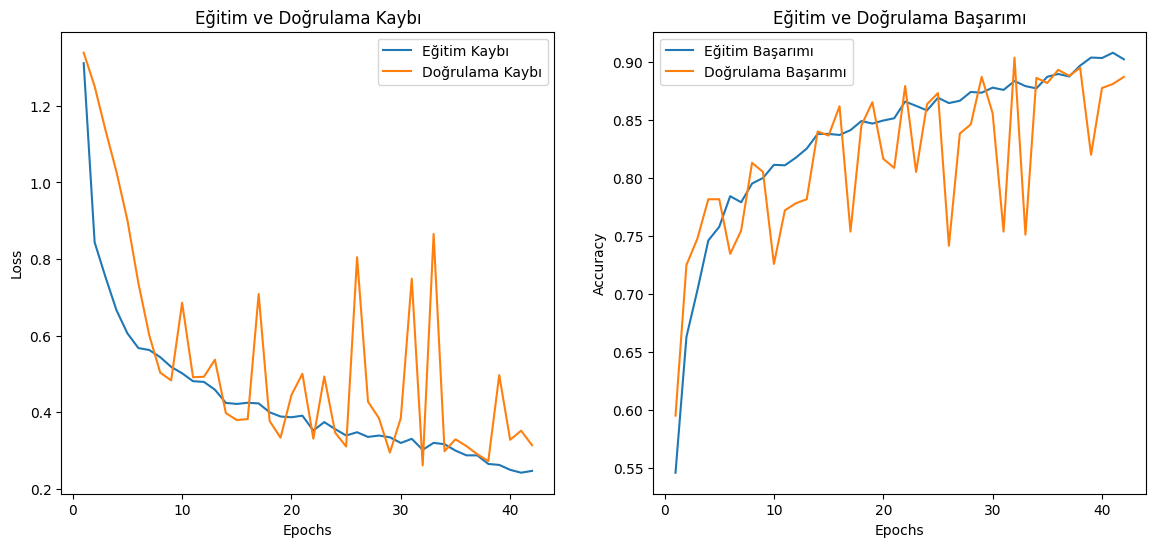

In [8]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 6))

# Kayıp (Loss)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Başarım (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Eğitim Başarımı')
plt.plot(epochs_range, val_accuracy, label='Doğrulama Başarımı')
plt.title('Eğitim ve Doğrulama Başarımı')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

--- Test Seti Değerlendirmesi ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 375s 19s/step - accuracy: 0.9233 - loss: 0.1941
Test Loss: 0.3599
Test Accuracy: %86.12
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

      glioma       0.87      0.81      0.84       300
  meningioma       0.77      0.67      0.72       306
     notumor       0.87      0.98      0.92       405
   pituitary       0.92      0.94      0.93       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



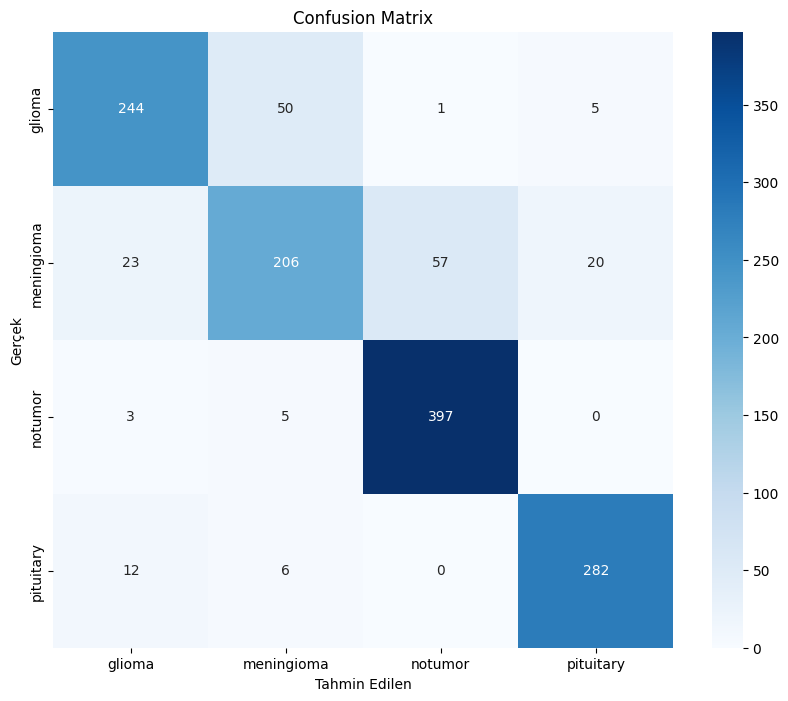

In [ ]:
print("--- Test Seti Değerlendirmesi ---")
results = model.evaluate(test_images, verbose=1)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: %{results[1]*100:.2f}")

# Tahminler
y_pred_probs = model.predict(test_images)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_images.classes
class_names = list(test_images.class_indices.keys())


print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm


print("Test verisi yükleniyor, lütfen bekleyin...")
test_images.reset() 
X_test, y_test_true = [], []

for i in range(len(test_images)):
    batch_x, batch_y = next(test_images)
    X_test.extend(batch_x)
    y_test_true.extend(batch_y)

X_test = np.array(X_test)
y_test_true = np.array(y_test_true) 
y_test_indices = np.argmax(y_test_true, axis=1) 


class_names = list(test_images.class_indices.keys())
print(f"Toplam Test Görüntüsü: {len(X_test)}")
print(f"Sınıflar: {class_names}")


print("Tahminler yapılıyor...")
y_pred_probs = model.predict(X_test, verbose=1)
y_pred_indices = np.argmax(y_pred_probs, axis=1)

Test verisi yükleniyor, lütfen bekleyin...
Toplam Test Görüntüsü: 1311
Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']
Tahminler yapılıyor...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


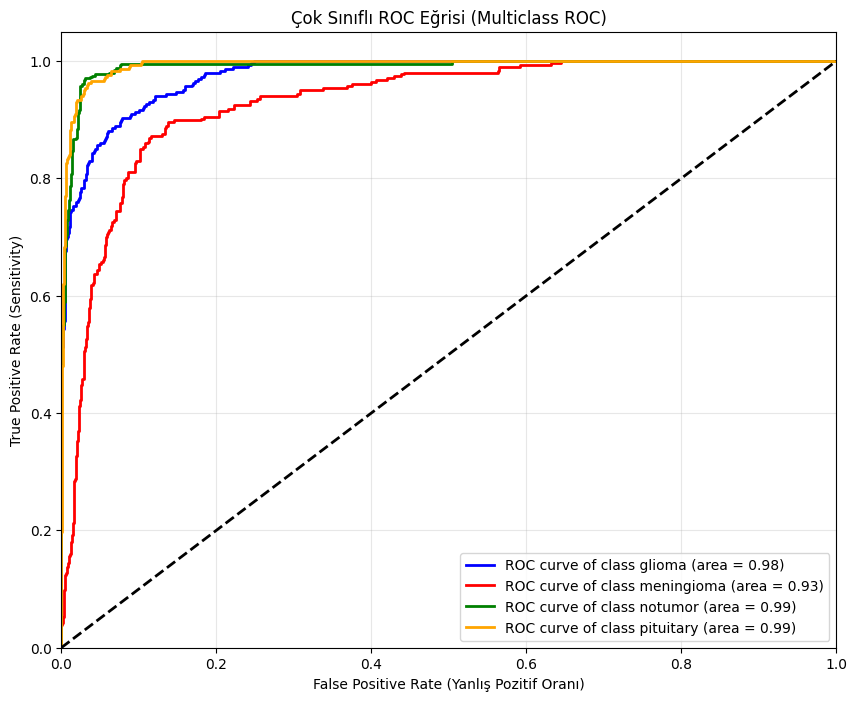

In [ ]:
# --- ROC Eğrisi ve AUC Hesaplama ---
n_classes = len(class_names)

# Her sınıf için ROC ve AUC hesapla
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafiği Çizdirme
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Çok Sınıflı ROC Eğrisi (Multiclass ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

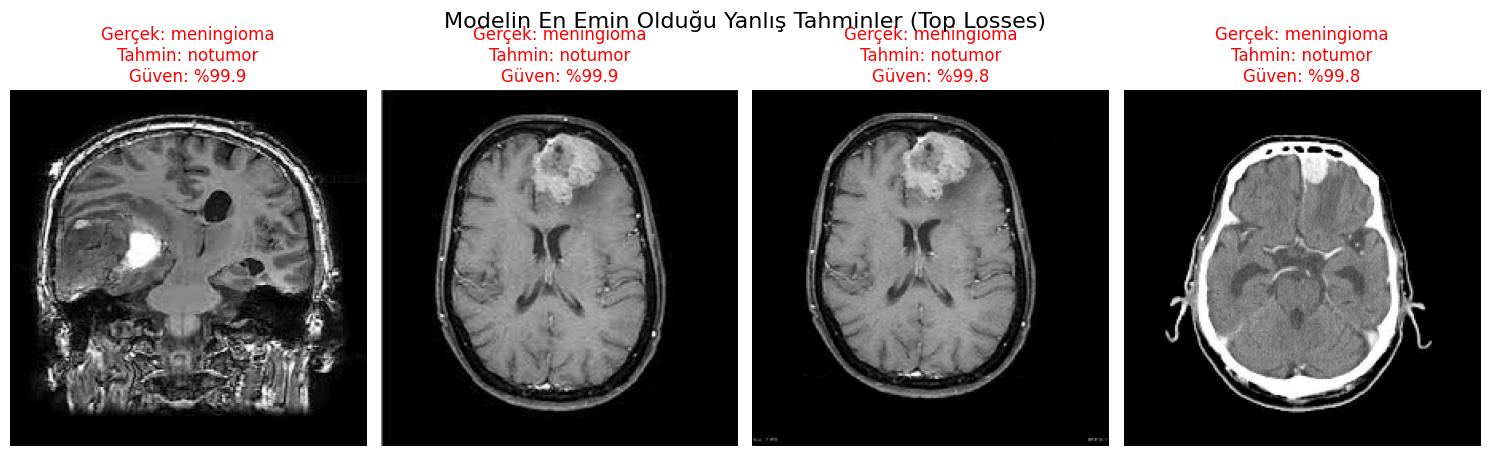

In [ ]:
# --- Hata Analizi: En Yüksek Güvenle Yapılan Yanlışlar ---


incorrect_indices = np.where(y_pred_indices != y_test_indices)[0]


incorrect_probs = np.max(y_pred_probs[incorrect_indices], axis=1)

top_incorrect_sorted = np.argsort(incorrect_probs)[::-1][:4]
top_incorrect_indices = incorrect_indices[top_incorrect_sorted]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(top_incorrect_indices):
    plt.subplot(1, 4, i + 1)

   
    plt.imshow(X_test[idx].reshape(224, 224), cmap='gray')

    true_label = class_names[y_test_indices[idx]]
    pred_label = class_names[y_pred_indices[idx]]
    confidence = np.max(y_pred_probs[idx])

    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\nGüven: %{confidence*100:.1f}", color='red')
    plt.axis('off')

plt.suptitle("Modelin En Emin Olduğu Yanlış Tahminler (Top Losses)", fontsize=16)
plt.tight_layout()
plt.show()

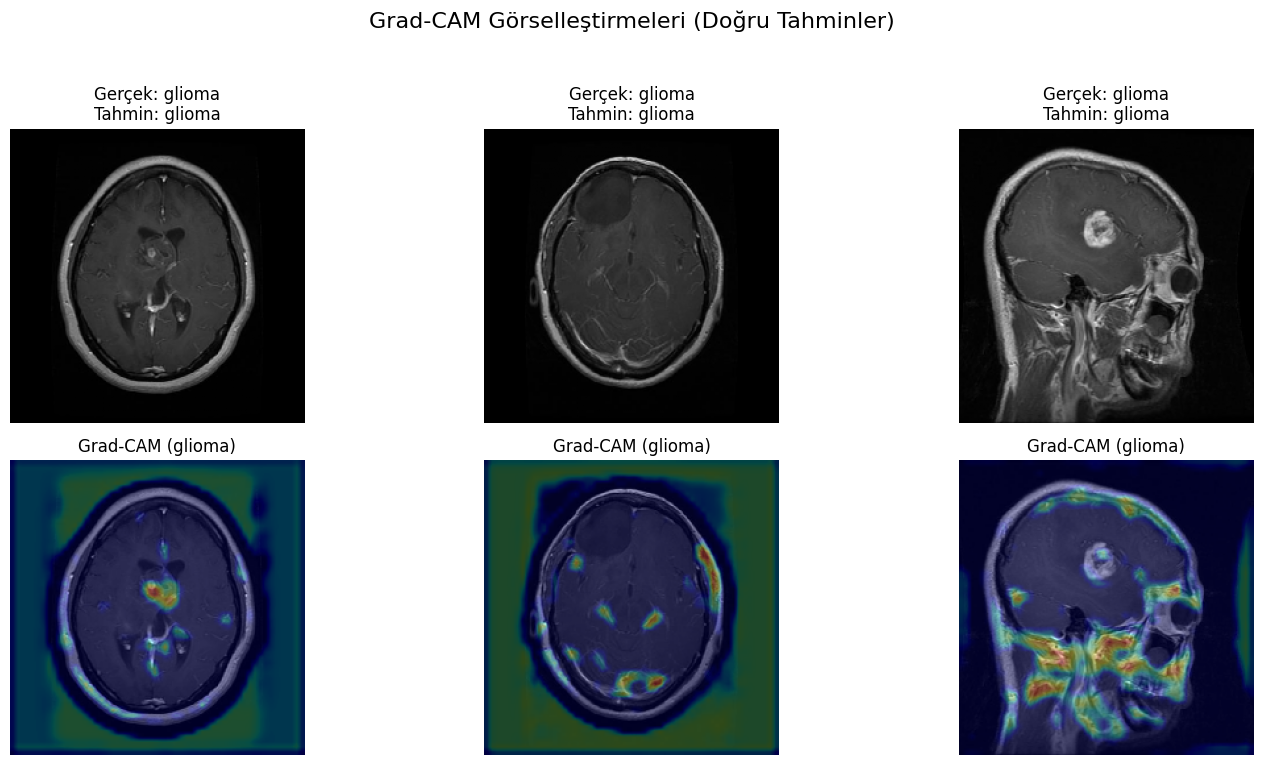

In [ ]:
# --- Grad-CAM Uygulaması ---

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    
    input_tensor = tf.keras.Input(shape=model.input_shape[1:])
    x = input_tensor
    conv_output = None
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x 

    
    final_output = x

   
    grad_model = tf.keras.models.Model(
        inputs=[input_tensor],
        outputs=[conv_output, final_output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

correct_indices = np.where(y_pred_indices == y_test_indices)[0]
sample_indices = np.random.choice(correct_indices, 3, replace=False)

last_conv_layer_name = 'conv2d_3'

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    img_array = np.expand_dims(img, axis=0)

    original_img_display = (img * 255).astype('uint8')

    pred_index = np.argmax(y_pred_probs[idx])

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

    heatmap = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = np.uint8(255 * heatmap)
 
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Görüntüyü renkli hale getirilmesi (tek kanallıdan 3 kanallıya)
    # Eğer orijinal resim grayscale ise, 3 kanala dönüştürülüyor
    if original_img_display.shape[-1] == 1:
        original_img_display = np.squeeze(original_img_display, axis=-1)
        original_img_display = cv2.cvtColor(original_img_display, cv2.COLOR_GRAY2BGR)
  
    superimposed_img = jet_heatmap * 0.4 + original_img_display / 255.0
    superimposed_img = (superimposed_img / np.max(superimposed_img) * 255).astype('uint8')

    
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.squeeze(img), cmap='gray') 
    true_label = class_names[y_test_indices[idx]]
    pred_label = class_names[y_pred_indices[idx]]
    plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}")
    plt.axis('off')

    plt.subplot(2, 3, i + 4) 
    plt.imshow(superimposed_img) 
    plt.title(f"Grad-CAM ({pred_label})")
    plt.axis('off')

plt.suptitle("Grad-CAM Görselleştirmeleri (Doğru Tahminler)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()